In [1]:
import os
import shutil
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input, Flatten, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

2024-08-06 17:21:07.461534: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-06 17:21:07.513556: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-06 17:21:08.298067: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

In [3]:
# Define paths
base_dir = '/home/user/GPU_CSE/Kirti/Dataset_for_Code_Development/Dataset_for_5_classes_by_Sir/DenseNet169'
dataset_dir = '/home/user/GPU_CSE/Kirti/Dataset_for_Code_Development/Dataset_for_5_classes_by_Sir/clean_train_partition'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [4]:
# Parameters
img_height, img_width = 224, 224  # ResNet50 requires images of size 224x224
batch_size = 32
num_classes = len(next(os.walk(dataset_dir))[1])  # number of class folders
train_ratio = 0.7
validation_ratio = 0.15
test_ratio = 0.15

In [5]:
# Function to create train, validation, and test splits
def create_splits():
    try:
        if not os.path.exists(train_dir):
            os.makedirs(train_dir)
        if not os.path.exists(validation_dir):
            os.makedirs(validation_dir)
        if not os.path.exists(test_dir):
            os.makedirs(test_dir)
    
        for class_name in os.listdir(dataset_dir):        
            train_class_path = os.path.join(train_dir, class_name)        
            if not os.path.exists(train_class_path):
                os.makedirs(train_class_path)        
            
            test_class_path = os.path.join(test_dir, class_name)        
            if not os.path.exists(test_class_path):
                os.makedirs(test_class_path)        
    
            validation_class_dir = os.path.join(validation_dir, class_name)       
            if not os.path.exists(validation_class_dir):
                os.makedirs(validation_class_dir)        
        
        for class_name in os.listdir(dataset_dir):        
            class_path = os.path.join(dataset_dir, class_name)
            
            if os.path.isdir(class_path):
                images = os.listdir(class_path)
                random.shuffle(images)
                train_split = int(train_ratio * len(images))
                validation_split = int(validation_ratio * len(images))
                
                train_images = images[:train_split]
                validation_images = images[train_split:train_split + validation_split]
                test_images = images[train_split + validation_split:]
    
                for image in train_images:
                    shutil.copy(os.path.join(class_path, image), os.path.join(train_dir, class_name, image))
                for image in validation_images:
                    shutil.copy(os.path.join(class_path, image), os.path.join(validation_dir, class_name, image))
                for image in test_images:
                    shutil.copy(os.path.join(class_path, image), os.path.join(test_dir, class_name, image))
    except Exception as err:
        print("Error:", str(err))

In [6]:
# Split the dataset
create_splits()

In [7]:
# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=(0.8, 1.2)
)

In [8]:
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 1083 images belonging to 5 classes.
Found 230 images belonging to 5 classes.
Found 239 images belonging to 5 classes.


In [10]:
# Load the DenseNet169 model pretrained on ImageNet
base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(1024, activation= 'relu', name = 'Dense_1024')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dense(512, activation='relu', name = 'Dense_512')(top_model)
predictions = Dense(num_classes, activation = 'softmax', name= 'Output_layer')(top_model)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('Architecture_no_1.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

2024-08-06 17:21:10.412039: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1010 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:86:00.0, compute capability: 8.6


51877672/51877672 [==============================] - 6s 0us/step


In [11]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/50


2024-08-06 17:21:29.709895: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8905
2024-08-06 17:21:29.961006: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-08-06 17:21:30.222558: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f7aad33f720 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-08-06 17:21:30.222585: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-08-06 17:21:30.228022: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-06 17:21:30.377671: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.

33/33 [==============================] - ETA: 0s - loss: 1.9274 - accuracy: 0.1931

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


33/33 [==============================] - 25s 500ms/step - loss: 1.9274 - accuracy: 0.1931 - val_loss: 1.8011 - val_accuracy: 0.1607
Epoch 2/50
33/33 [==============================] - 15s 446ms/step - loss: 1.8964 - accuracy: 0.2065 - val_loss: 1.7237 - val_accuracy: 0.1562
Epoch 3/50
33/33 [==============================] - 15s 443ms/step - loss: 1.8253 - accuracy: 0.2027 - val_loss: 1.6897 - val_accuracy: 0.1920
Epoch 4/50
33/33 [==============================] - 15s 449ms/step - loss: 1.7758 - accuracy: 0.2417 - val_loss: 1.6770 - val_accuracy: 0.1696
Epoch 5/50
33/33 [==============================] - 15s 448ms/step - loss: 1.6819 - accuracy: 0.2778 - val_loss: 1.6621 - val_accuracy: 0.1964
Epoch 6/50
33/33 [==============================] - 14s 409ms/step - loss: 1.7255 - accuracy: 0.2483 - val_loss: 1.6744 - val_accuracy: 0.2098
Epoch 7/50
33/33 [==============================] - 14s 410ms/step - loss: 1.6851 - accuracy: 0.2664 - val_loss: 1.6868 - val_accuracy: 0.2143
Epoch 8/50

In [12]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy:.2f}')

8/8 [==============================] - 1s 90ms/step - loss: 1.6560 - accuracy: 0.2552
Test accuracy: 0.26


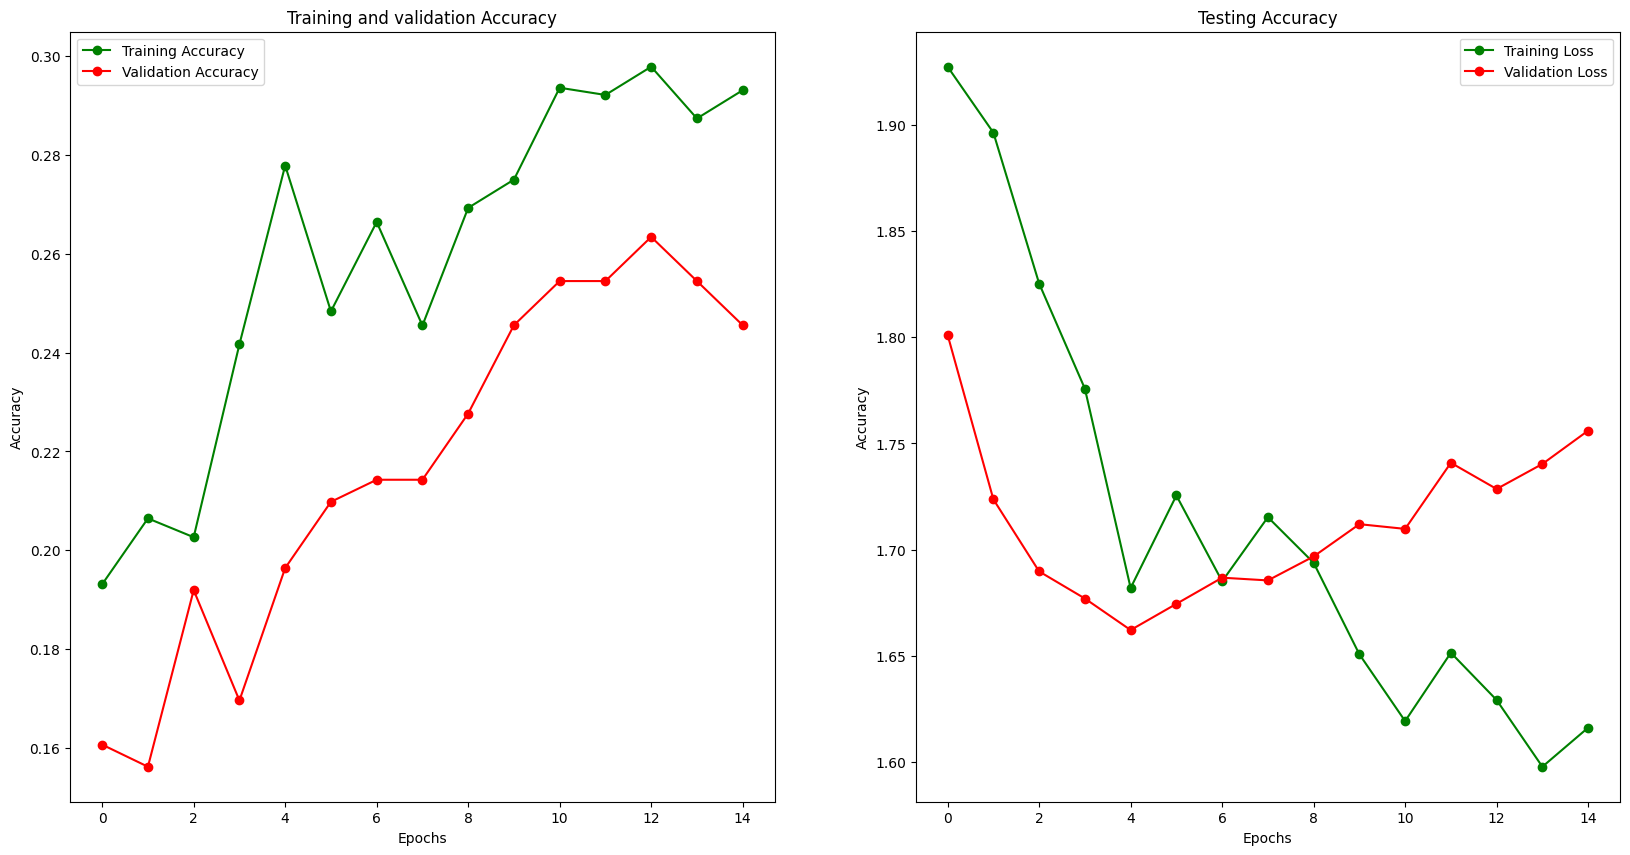

In [13]:
epochs = [i for i in range(len(history.epoch))]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training and validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'go-', label = 'Training Loss')
ax[1].plot(epochs, val_loss, 'ro-', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
plt.show()

8/8 [==============================] - 3s 78ms/step


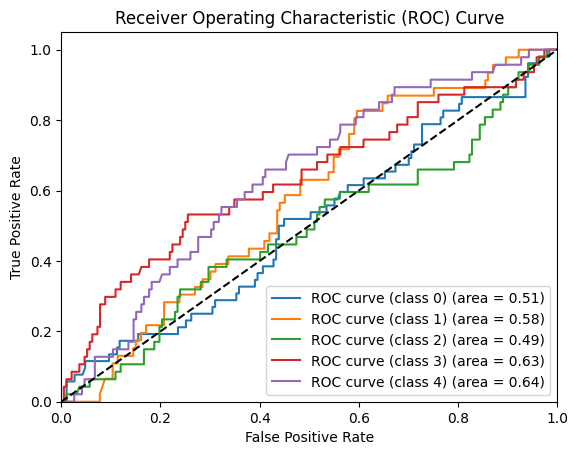

In [14]:
# Predict probabilities for the test set
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_true = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Architecture No 2

In [15]:
# Load the DenseNet169 model pretrained on ImageNet
base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last few layers of the base model
for layer in base_model.layers[-2:]:  # Change the number of layers to unfreeze as needed
    layer.trainable = True

top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(1024, activation= 'relu', name = 'Dense_1024')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dense(512, activation='relu', name = 'Dense_512')(top_model)
predictions = Dense(num_classes, activation = 'softmax', name= 'Output_layer')(top_model)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('Architecture_no_2.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [16]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/50
33/33 [==============================] - ETA: 0s - loss: 2.0254 - accuracy: 0.1789

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


33/33 [==============================] - 25s 496ms/step - loss: 2.0254 - accuracy: 0.1789 - val_loss: 1.6817 - val_accuracy: 0.2455
Epoch 2/50
33/33 [==============================] - 15s 438ms/step - loss: 1.9198 - accuracy: 0.2131 - val_loss: 1.6574 - val_accuracy: 0.2321
Epoch 3/50
33/33 [==============================] - 15s 442ms/step - loss: 1.9074 - accuracy: 0.2312 - val_loss: 1.6505 - val_accuracy: 0.2277
Epoch 4/50
33/33 [==============================] - 15s 447ms/step - loss: 1.8619 - accuracy: 0.2065 - val_loss: 1.6429 - val_accuracy: 0.2455
Epoch 5/50
33/33 [==============================] - 13s 405ms/step - loss: 1.7783 - accuracy: 0.2369 - val_loss: 1.6535 - val_accuracy: 0.2321
Epoch 6/50
33/33 [==============================] - 15s 441ms/step - loss: 1.7509 - accuracy: 0.2464 - val_loss: 1.6412 - val_accuracy: 0.2589
Epoch 7/50
33/33 [==============================] - 14s 409ms/step - loss: 1.7195 - accuracy: 0.2578 - val_loss: 1.6725 - val_accuracy: 0.2277
Epoch 8/50

In [17]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy:.2f}')

8/8 [==============================] - 1s 72ms/step - loss: 1.6545 - accuracy: 0.2594
Test accuracy: 0.26


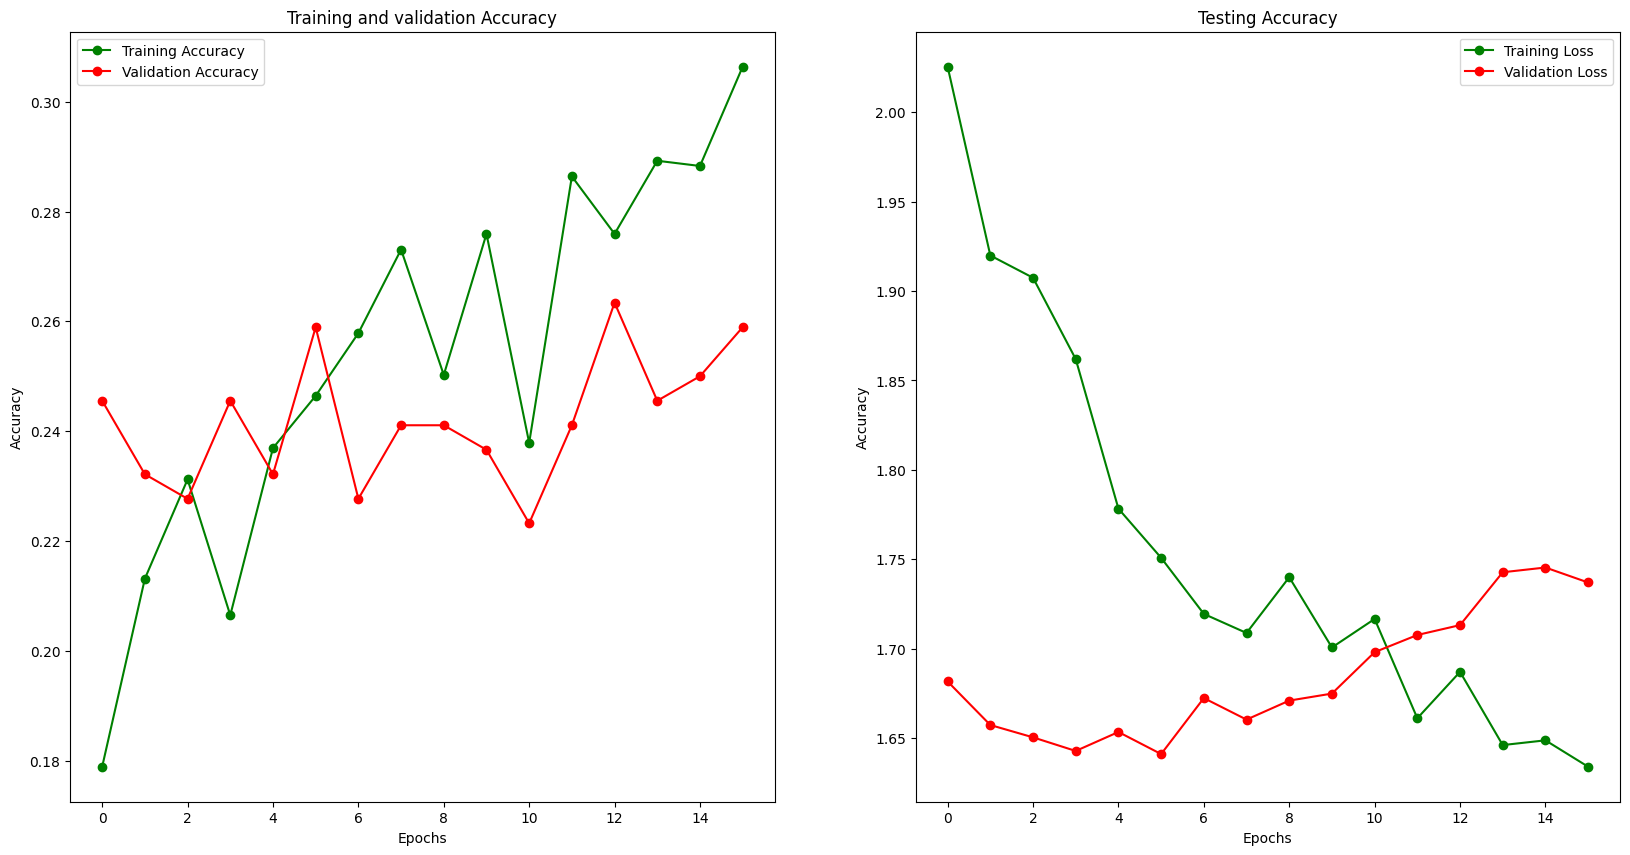

In [18]:
epochs = [i for i in range(len(history.epoch))]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training and validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'go-', label = 'Training Loss')
ax[1].plot(epochs, val_loss, 'ro-', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
plt.show()

8/8 [==============================] - 3s 71ms/step


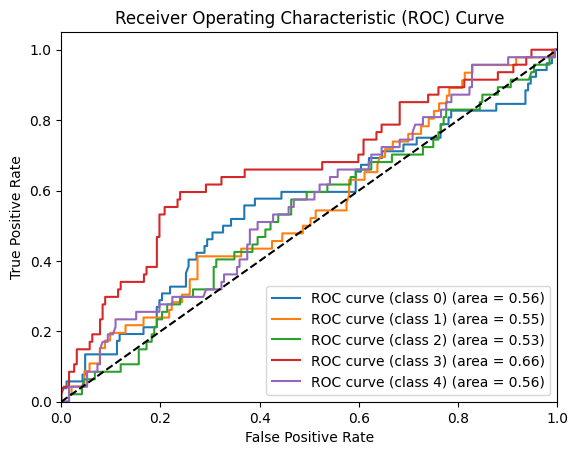

In [19]:
# Predict probabilities for the test set
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_true = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Architecture No 4

In [20]:
# Load the DenseNet169 model pretrained on ImageNet
base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last few layers of the base model
for layer in base_model.layers[-3:]:  # Change the number of layers to unfreeze as needed
    layer.trainable = True

top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(1024, activation= 'relu', name = 'Dense_1024')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dense(512, activation='relu', name = 'Dense_512')(top_model)
predictions = Dense(num_classes, activation = 'softmax', name= 'Output_layer')(top_model)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('Architecture_no_4.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [21]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/50
33/33 [==============================] - ETA: 0s - loss: 1.8563 - accuracy: 0.2169

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


33/33 [==============================] - 25s 506ms/step - loss: 1.8563 - accuracy: 0.2169 - val_loss: 1.6349 - val_accuracy: 0.2188
Epoch 2/50
33/33 [==============================] - 15s 445ms/step - loss: 1.6415 - accuracy: 0.2826 - val_loss: 1.6137 - val_accuracy: 0.2366
Epoch 3/50
33/33 [==============================] - 14s 406ms/step - loss: 1.6324 - accuracy: 0.3045 - val_loss: 1.6163 - val_accuracy: 0.2411
Epoch 4/50
33/33 [==============================] - 15s 449ms/step - loss: 1.5786 - accuracy: 0.3159 - val_loss: 1.5978 - val_accuracy: 0.2946
Epoch 5/50
33/33 [==============================] - 14s 413ms/step - loss: 1.5552 - accuracy: 0.3311 - val_loss: 1.6123 - val_accuracy: 0.2679
Epoch 6/50
33/33 [==============================] - 14s 411ms/step - loss: 1.5135 - accuracy: 0.3473 - val_loss: 1.6212 - val_accuracy: 0.2723
Epoch 7/50
33/33 [==============================] - 14s 410ms/step - loss: 1.5221 - accuracy: 0.3302 - val_loss: 1.6318 - val_accuracy: 0.2455
Epoch 8/50

In [22]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy:.2f}')

8/8 [==============================] - 1s 69ms/step - loss: 1.6267 - accuracy: 0.2720
Test accuracy: 0.27


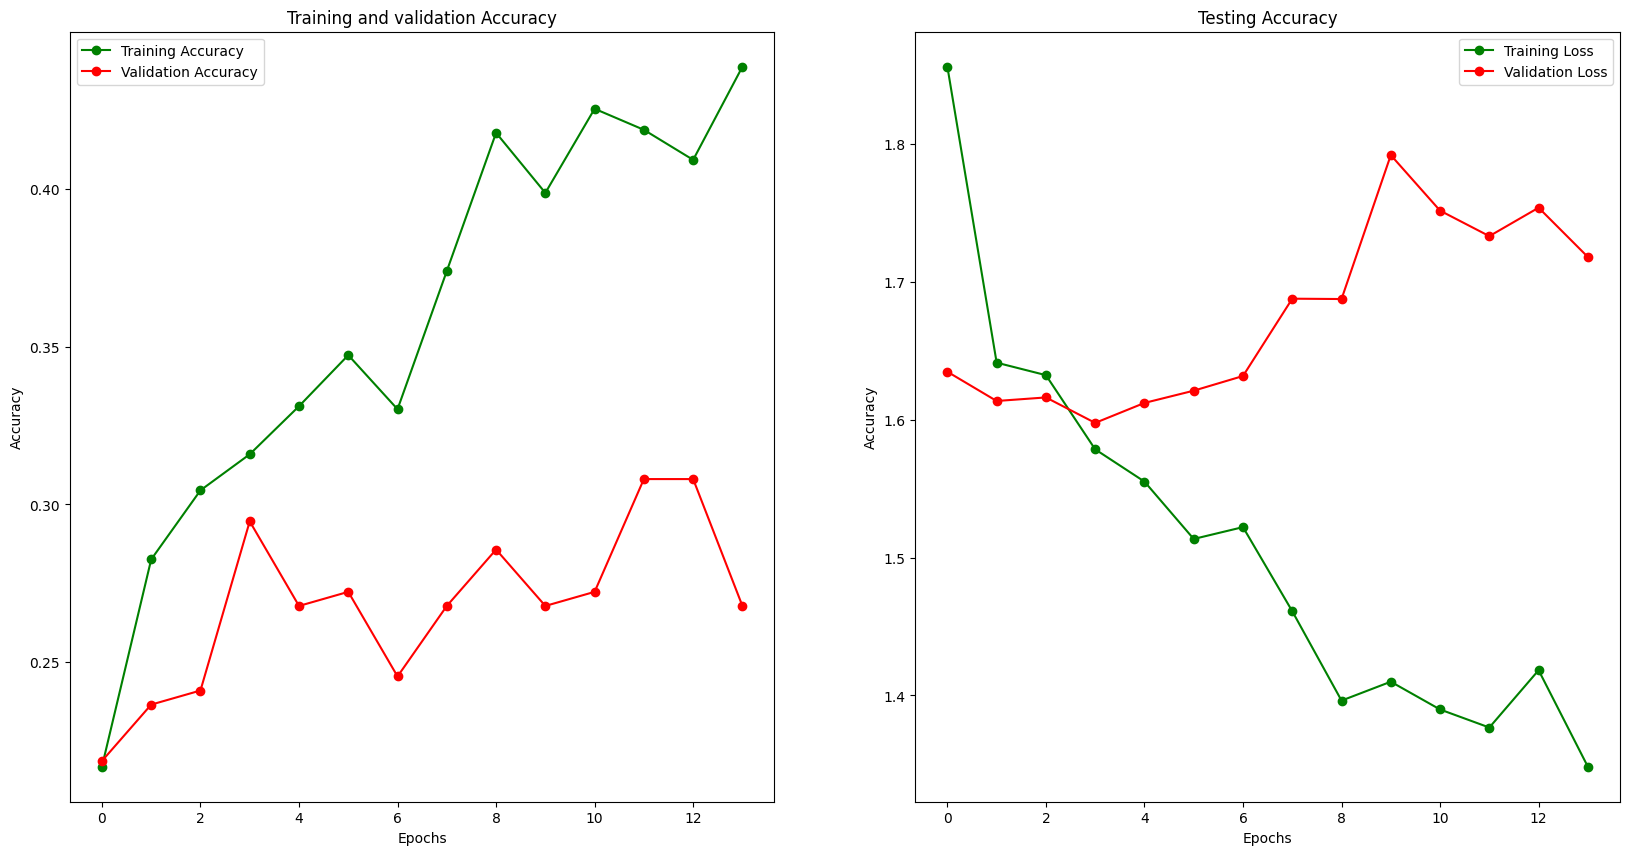

In [23]:
epochs = [i for i in range(len(history.epoch))]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training and validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'go-', label = 'Training Loss')
ax[1].plot(epochs, val_loss, 'ro-', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
plt.show()

8/8 [==============================] - 3s 66ms/step


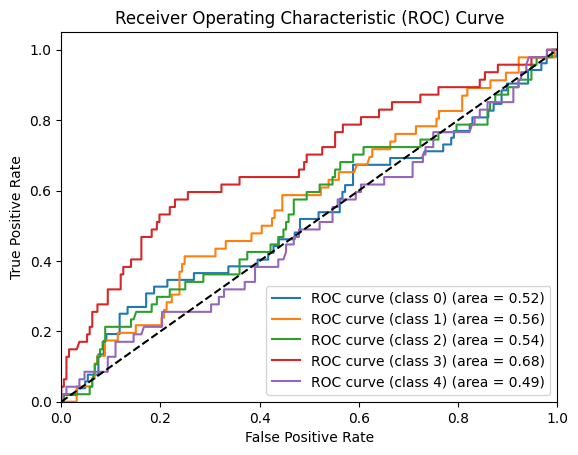

In [24]:
# Predict probabilities for the test set
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_true = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Architecture No 5

In [25]:
# Load the DenseNet169 model pretrained on ImageNet
base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last few layers of the base model
for layer in base_model.layers[-4:]:  # Change the number of layers to unfreeze as needed
    layer.trainable = True

top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(1024, activation= 'relu', name = 'Dense_1024')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dense(512, activation='relu', name = 'Dense_512')(top_model)
predictions = Dense(num_classes, activation = 'softmax', name= 'Output_layer')(top_model)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('Architecture_no_5.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [26]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)


Epoch 1/50
33/33 [==============================] - ETA: 0s - loss: 1.8301 - accuracy: 0.2274

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


33/33 [==============================] - 29s 530ms/step - loss: 1.8301 - accuracy: 0.2274 - val_loss: 1.6798 - val_accuracy: 0.2545
Epoch 2/50
33/33 [==============================] - 15s 442ms/step - loss: 1.6856 - accuracy: 0.2864 - val_loss: 1.6640 - val_accuracy: 0.2411
Epoch 3/50
33/33 [==============================] - 15s 440ms/step - loss: 1.5962 - accuracy: 0.3368 - val_loss: 1.6112 - val_accuracy: 0.2545
Epoch 4/50
33/33 [==============================] - 15s 441ms/step - loss: 1.5116 - accuracy: 0.3654 - val_loss: 1.5727 - val_accuracy: 0.2634
Epoch 5/50
33/33 [==============================] - 14s 410ms/step - loss: 1.4982 - accuracy: 0.3644 - val_loss: 1.5822 - val_accuracy: 0.2812
Epoch 6/50
33/33 [==============================] - 14s 411ms/step - loss: 1.5091 - accuracy: 0.3578 - val_loss: 1.6304 - val_accuracy: 0.2634
Epoch 7/50
33/33 [==============================] - 14s 415ms/step - loss: 1.4470 - accuracy: 0.3796 - val_loss: 1.7031 - val_accuracy: 0.2679
Epoch 8/50

In [27]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy:.2f}')

8/8 [==============================] - 1s 80ms/step - loss: 1.5821 - accuracy: 0.2887
Test accuracy: 0.29


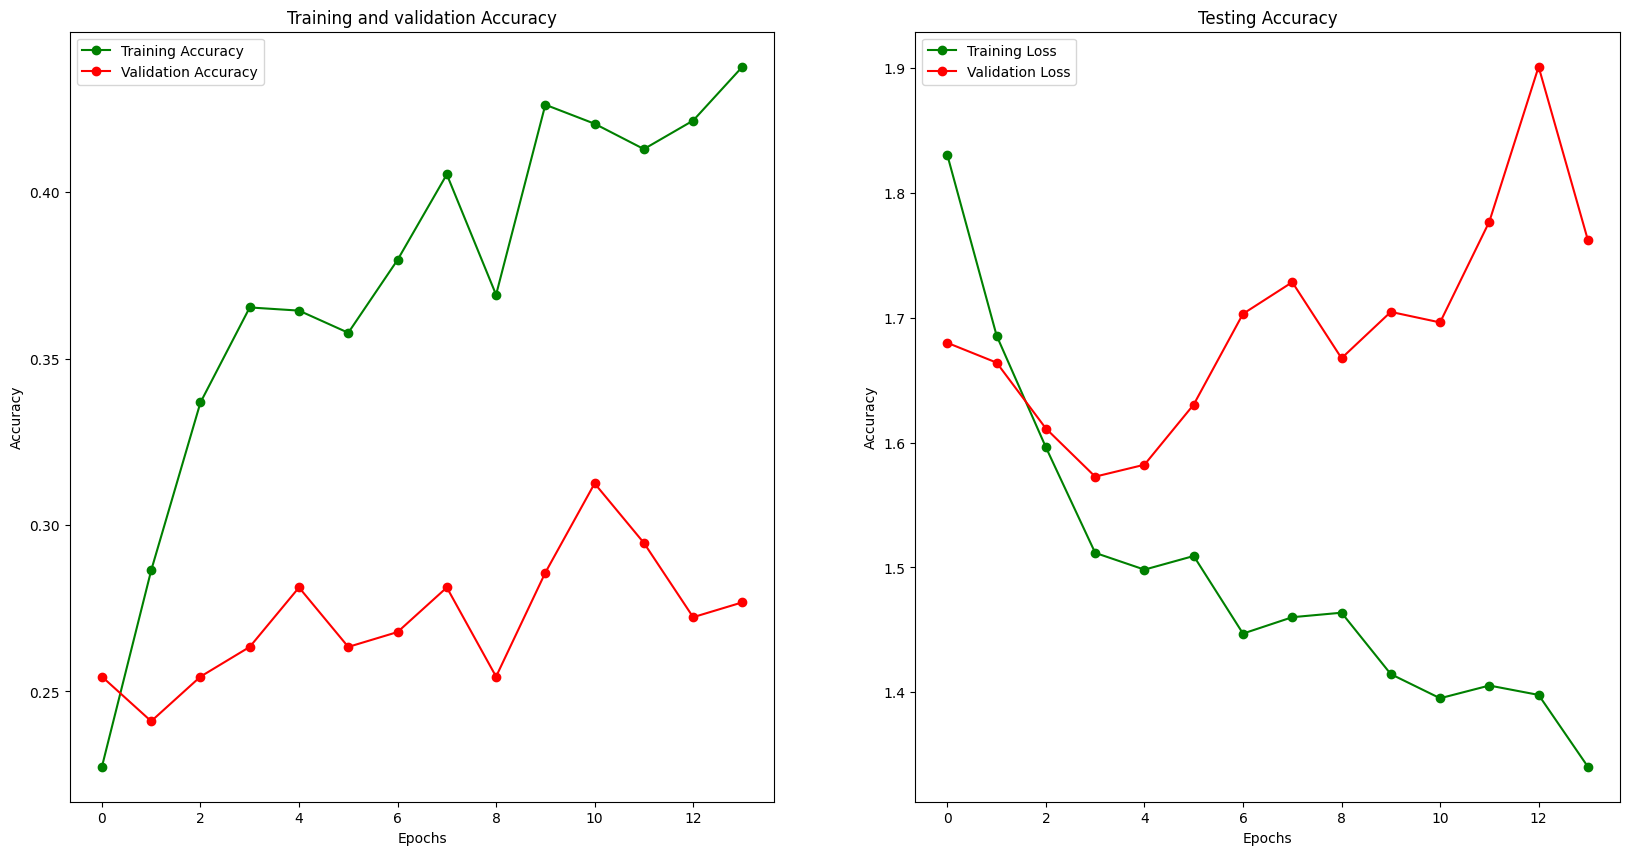

In [28]:
epochs = [i for i in range(len(history.epoch))]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training and validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'go-', label = 'Training Loss')
ax[1].plot(epochs, val_loss, 'ro-', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
plt.show()

8/8 [==============================] - 3s 70ms/step


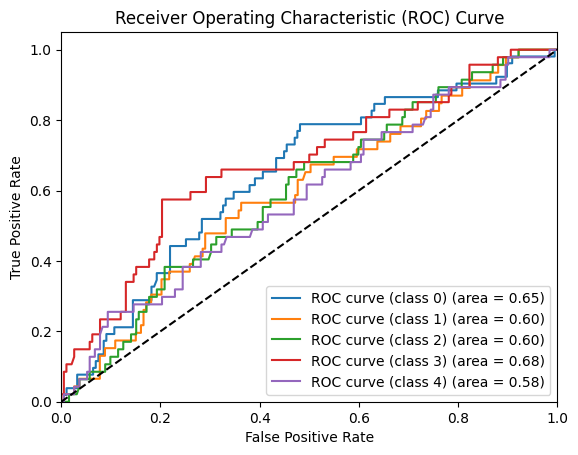

In [29]:
# Predict probabilities for the test set
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_true = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Architecture No 6

In [30]:
# Load the DenseNet169 model pretrained on ImageNet
base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last few layers of the base model
for layer in base_model.layers[-4:]:  # Change the number of layers to unfreeze as needed
    layer.trainable = True

top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(1024, activation= 'relu', name = 'Dense_1024')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dense(512, activation='relu', name = 'Dense_512')(top_model)
top_model = Dropout(0.3)(top_model)
top_model = Dense(64, activation='relu', name = 'Dense_64')(top_model)
predictions = Dense(num_classes, activation = 'softmax', name= 'Output_layer')(top_model)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('Architecture_no_6.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [31]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/50
33/33 [==============================] - ETA: 0s - loss: 1.9088 - accuracy: 0.2369

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


33/33 [==============================] - 26s 498ms/step - loss: 1.9088 - accuracy: 0.2369 - val_loss: 1.6204 - val_accuracy: 0.2098
Epoch 2/50
33/33 [==============================] - 15s 442ms/step - loss: 1.7609 - accuracy: 0.2559 - val_loss: 1.6029 - val_accuracy: 0.2455
Epoch 3/50
33/33 [==============================] - 15s 443ms/step - loss: 1.6599 - accuracy: 0.2902 - val_loss: 1.6000 - val_accuracy: 0.2500
Epoch 4/50
33/33 [==============================] - 15s 440ms/step - loss: 1.6549 - accuracy: 0.3035 - val_loss: 1.5654 - val_accuracy: 0.2679
Epoch 5/50
33/33 [==============================] - 15s 448ms/step - loss: 1.5969 - accuracy: 0.3149 - val_loss: 1.5607 - val_accuracy: 0.2857
Epoch 6/50
33/33 [==============================] - 14s 412ms/step - loss: 1.5887 - accuracy: 0.3187 - val_loss: 1.5688 - val_accuracy: 0.2812
Epoch 7/50
33/33 [==============================] - 15s 441ms/step - loss: 1.5779 - accuracy: 0.3283 - val_loss: 1.5581 - val_accuracy: 0.2946
Epoch 8/50

In [32]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy:.2f}')

8/8 [==============================] - 1s 75ms/step - loss: 1.5892 - accuracy: 0.2845
Test accuracy: 0.28


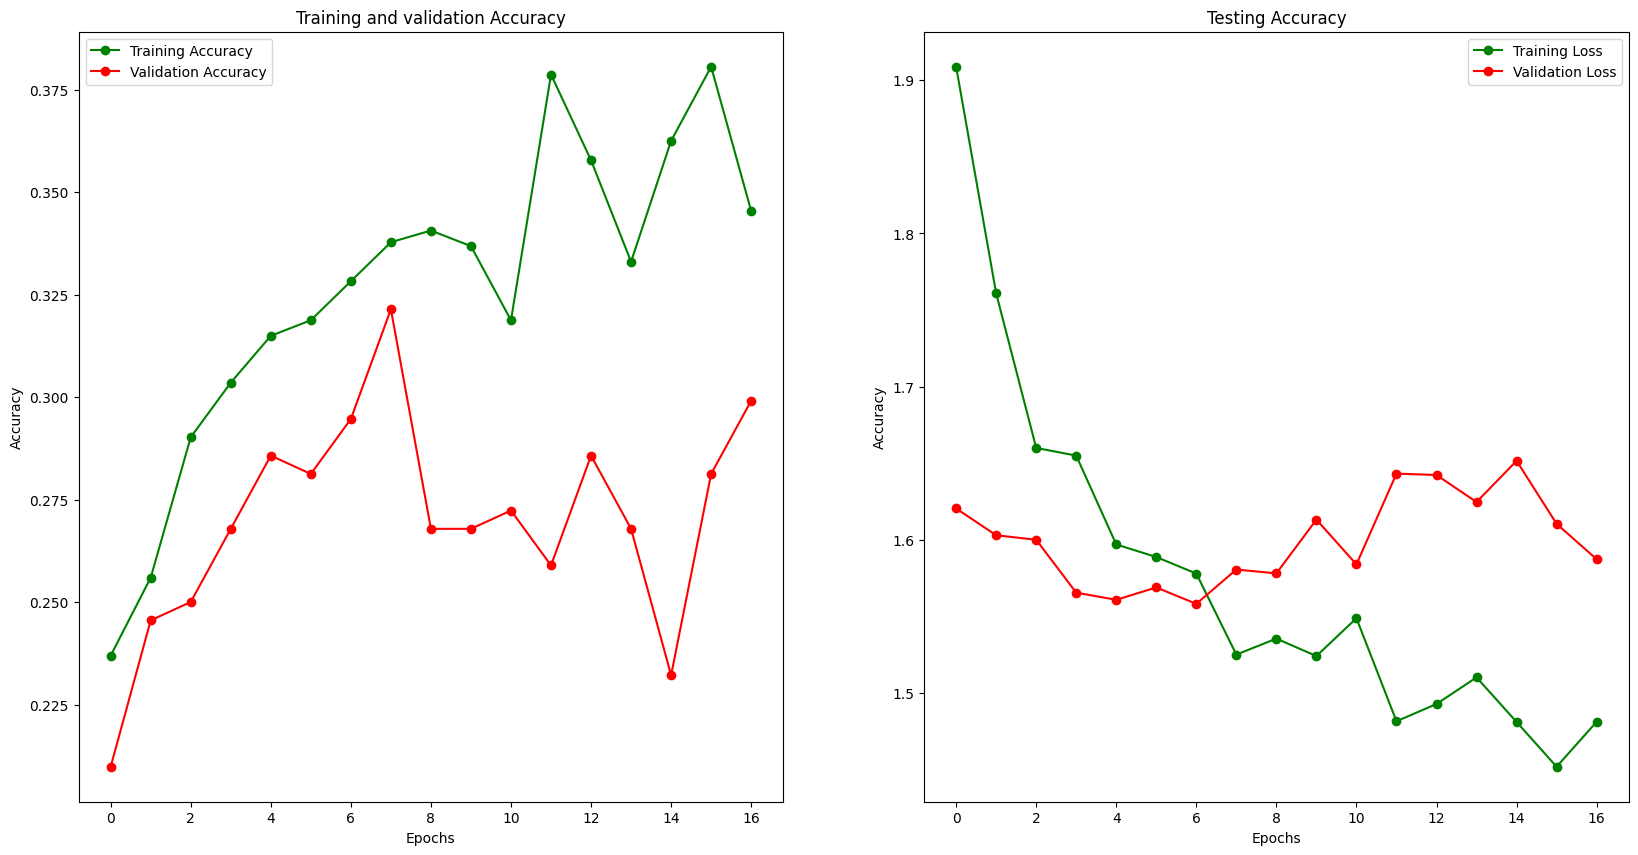

In [33]:
epochs = [i for i in range(len(history.epoch))]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training and validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'go-', label = 'Training Loss')
ax[1].plot(epochs, val_loss, 'ro-', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
plt.show()

8/8 [==============================] - 3s 81ms/step


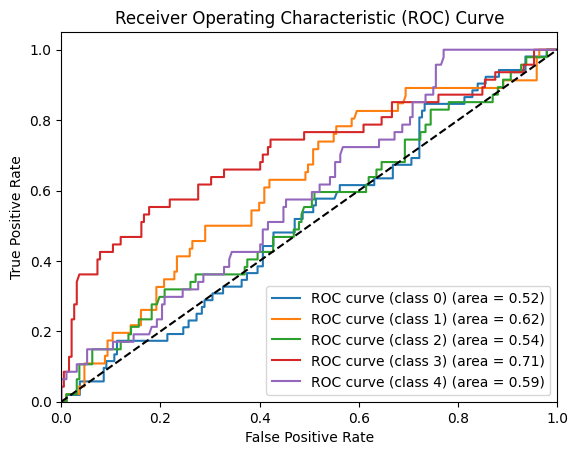

In [34]:
# Predict probabilities for the test set
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_true = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Architecture No 7

In [35]:
# Load the DenseNet169 model pretrained on ImageNet
base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last few layers of the base model
for layer in base_model.layers[-4:]:  # Change the number of layers to unfreeze as needed
    layer.trainable = True

top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(2048, activation= 'relu', name = 'Dense_1024')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dense(1024, activation='relu', name = 'Dense_512')(top_model)
top_model = Dropout(0.3)(top_model)
top_model = Dense(512, activation='relu', name = 'Dense_64')(top_model)
predictions = Dense(num_classes, activation = 'softmax', name= 'Output_layer')(top_model)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('Architecture_no_7.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [36]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/50
33/33 [==============================] - ETA: 0s - loss: 1.8220 - accuracy: 0.2084

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


33/33 [==============================] - 26s 516ms/step - loss: 1.8220 - accuracy: 0.2084 - val_loss: 1.5929 - val_accuracy: 0.2455
Epoch 2/50
33/33 [==============================] - 15s 447ms/step - loss: 1.7001 - accuracy: 0.2769 - val_loss: 1.5922 - val_accuracy: 0.2277
Epoch 3/50
33/33 [==============================] - 14s 407ms/step - loss: 1.6399 - accuracy: 0.2921 - val_loss: 1.5968 - val_accuracy: 0.2500
Epoch 4/50
33/33 [==============================] - 15s 440ms/step - loss: 1.5574 - accuracy: 0.3292 - val_loss: 1.5693 - val_accuracy: 0.2634
Epoch 5/50
33/33 [==============================] - 14s 408ms/step - loss: 1.5351 - accuracy: 0.3349 - val_loss: 1.6068 - val_accuracy: 0.2411
Epoch 6/50
33/33 [==============================] - 15s 447ms/step - loss: 1.5228 - accuracy: 0.3616 - val_loss: 1.5566 - val_accuracy: 0.2946
Epoch 7/50
33/33 [==============================] - 15s 440ms/step - loss: 1.4795 - accuracy: 0.3815 - val_loss: 1.5539 - val_accuracy: 0.2812
Epoch 8/50

In [37]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy:.2f}')

8/8 [==============================] - 1s 70ms/step - loss: 1.5416 - accuracy: 0.3347
Test accuracy: 0.33


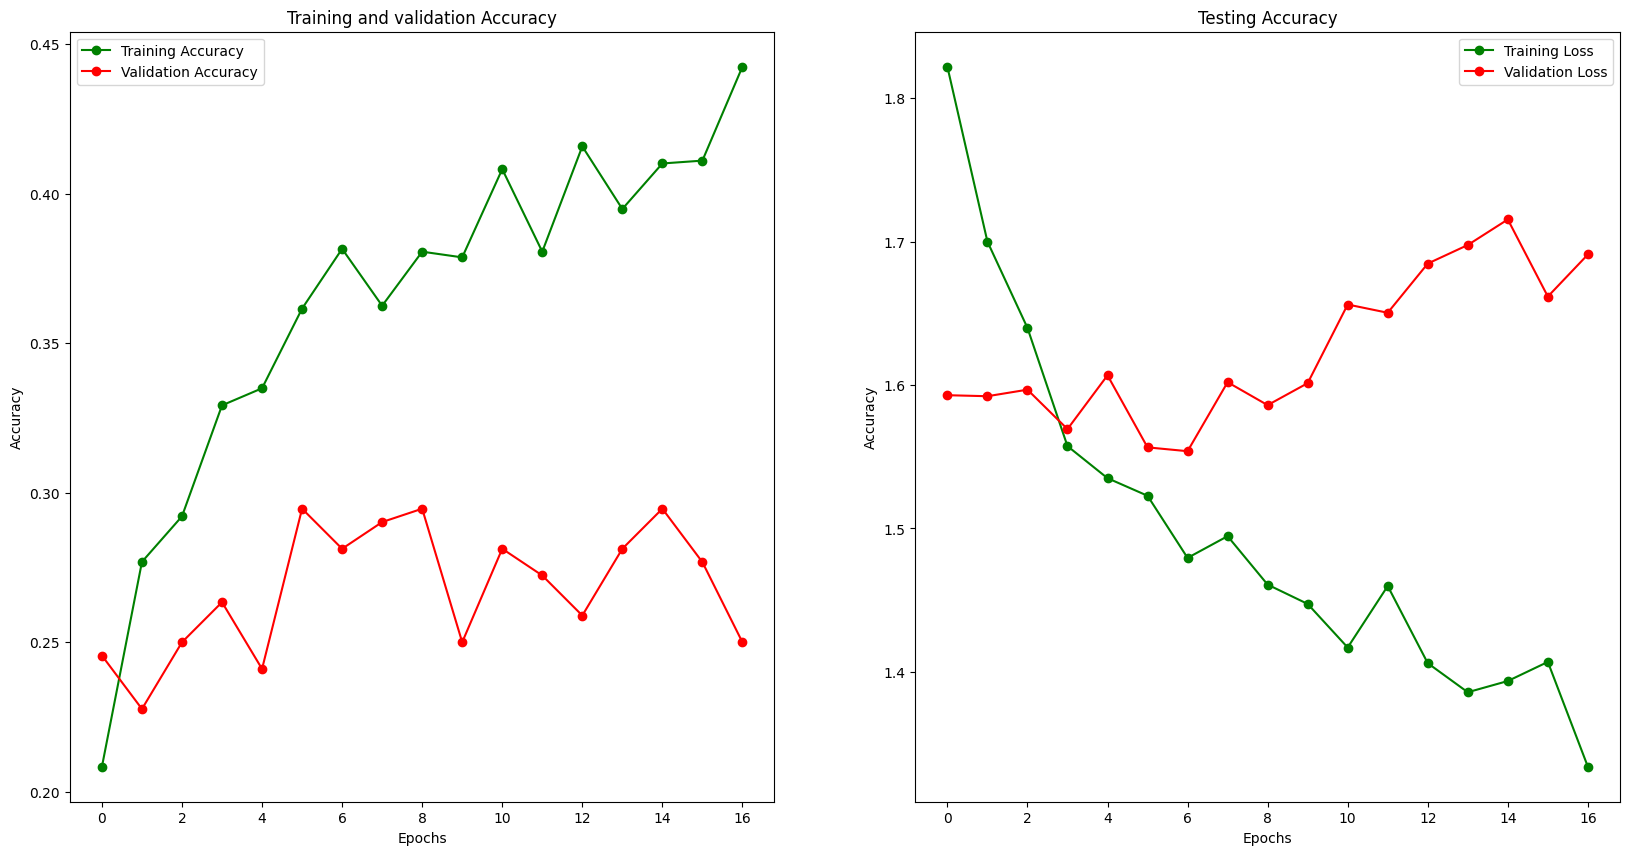

In [38]:
epochs = [i for i in range(len(history.epoch))]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training and validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'go-', label = 'Training Loss')
ax[1].plot(epochs, val_loss, 'ro-', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
plt.show()

8/8 [==============================] - 3s 87ms/step


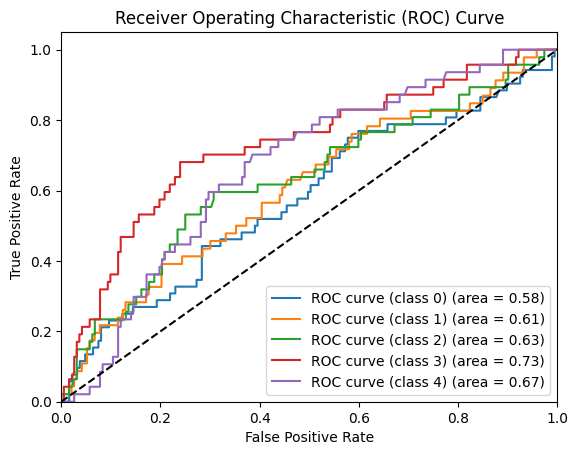

In [39]:
# Predict probabilities for the test set
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_true = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
